In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
from matplotlib.lines import Line2D
import duckdb
import json

In [5]:
with open("credentials.json") as f:
    d = json.load(f)

pg = d["postgres"]
aws = d["aws"]
bucket = "s3://carlos-s3-bdet-ducklake" 

def secreto(con):
    print("Iniciando")
    #con = duckdb.connect( )
    con.sql("INSTALL ducklake; LOAD ducklake;")
    con.sql("INSTALL spatial; LOAD spatial;")
    con.sql("INSTALL httpfs; LOAD httpfs;")
    con.sql("INSTALL postgres; LOAD postgres;")

    print("Librerias cargadas")

    con.sql(f"""
        CREATE OR REPLACE SECRET secreto_s3 (
        TYPE s3,
        KEY_ID '{aws["login"]}',
        SECRET '{aws["password"]}',
        REGION 'eu-central-1'
    )
    """)

    print("Secreto s3 creado")

    con.sql(f"""
        CREATE OR REPLACE SECRET secreto_postgres (
        TYPE postgres,
        HOST '{pg["host"]}',
        PORT {pg["port"]},
        DATABASE '{pg["schema"]}',
        USER '{pg["login"]}',
        PASSWORD '{pg["password"]}'
        )
    """)

    print("Secreto postgres creado")

    con.sql("""
        CREATE OR REPLACE SECRET secreto_ducklake (
            TYPE ducklake,
            METADATA_PATH '',
            METADATA_PARAMETERS MAP {'TYPE': 'postgres', 'SECRET': 'secreto_postgres'}
        );
        """)
    
    print("secreto ducklake creado")

    con.sql(f"""
        ATTACH 'ducklake:secreto_ducklake' AS mobility_ducklake (DATA_PATH '{bucket}', OVERRIDE_DATA_PATH TRUE) """)
    con.sql("""
        USE mobility_ducklake """)
    
    print("fin")

In [4]:
con = duckdb.connect()
secreto(con)

Iniciando
Librerias cargadas
Secreto s3 creado
Secreto postgres creado
secreto ducklake creado
fin


In [17]:
df = con.sql("SELECT p.date, pattern_type as cluster, is_holiday FROM gold_date_patterns p LEFT JOIN silver_festivos f ON p.date=f.date").df()

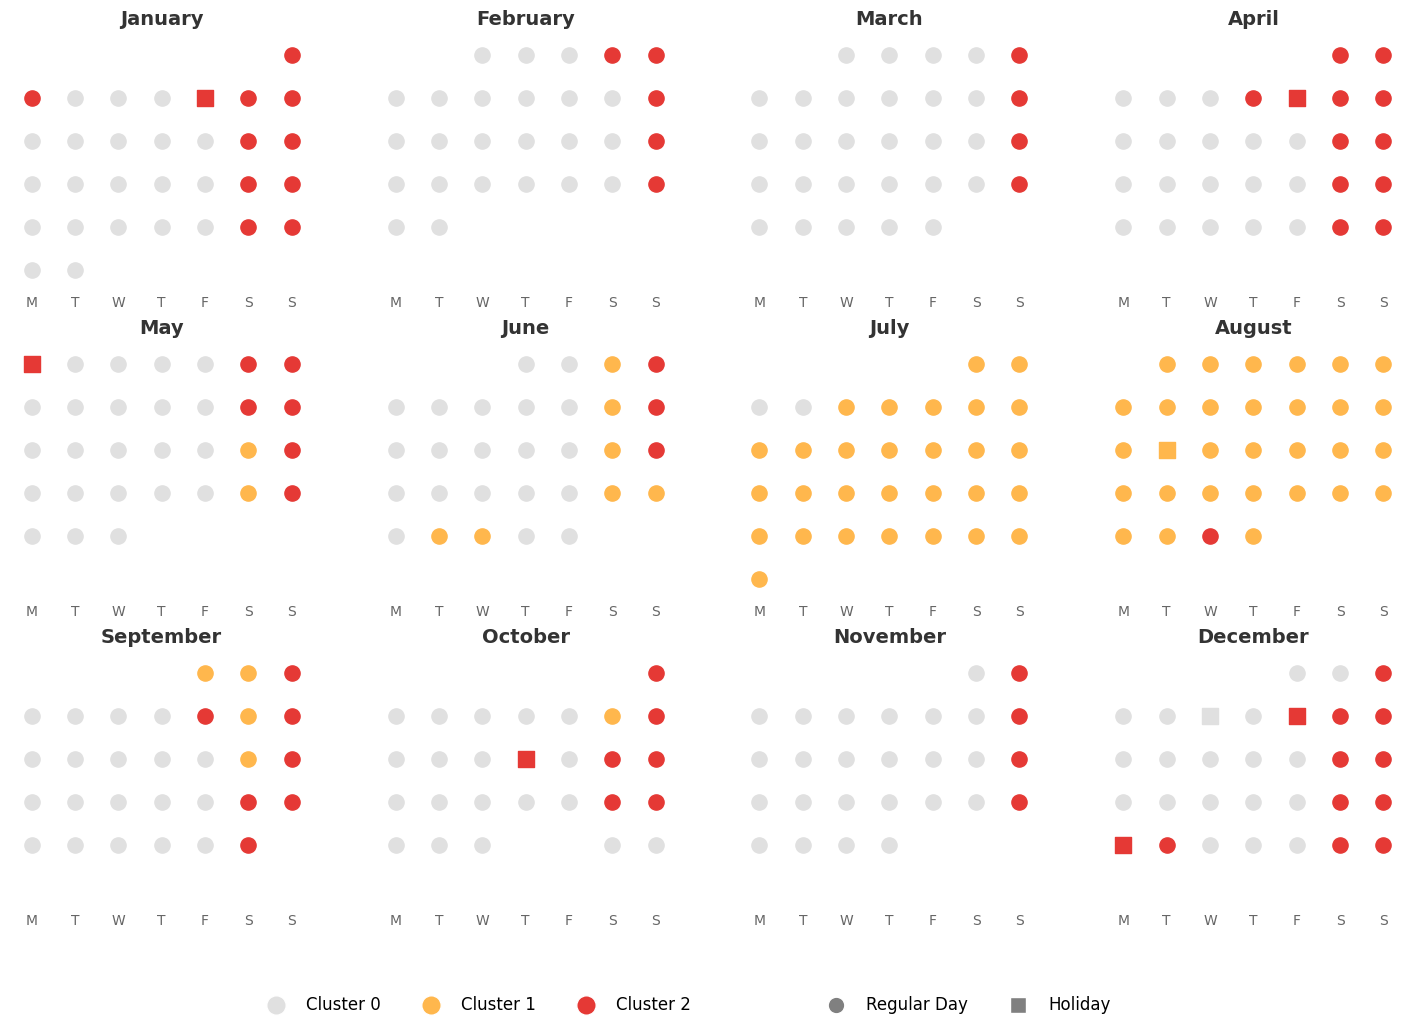

In [18]:


# --- 1. CARGA DE DATOS ---
# Asumimos que 'df' viene de tu consulta DuckDB
# df = con.sql("SELECT date, pattern_type as cluster, is_holiday FROM ...").df()
# Asegúrate de que 'date' es datetime
df['date'] = pd.to_datetime(df['date'])

# --- 2. CONFIGURACIÓN ---
# Colores por Cluster (Ajusta según cuántos K te salgan)
CLUSTER_COLORS = {
    0: '#E0E0E0',  # Gris (Cluster 0)
    1: '#FFB74D',  # Naranja (Cluster 1)
    2: '#E53935',  # Rojo (Cluster 2)
    3: '#1E88E5'   # Azul (Si hubiera Cluster 3)
}

fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.flatten()
year = 2023

# --- 3. GENERACIÓN DEL GRÁFICO ---
for i, month in enumerate(range(1, 13)):
    ax = axes[i]
    month_matrix = calendar.monthcalendar(year, month)
    
    for y, week in enumerate(month_matrix):
        for x, day in enumerate(week):
            if day == 0: continue 
            
            # Buscar datos del día
            current_date = pd.Timestamp(year=year, month=month, day=day)
            row = df[df['date'] == current_date]
            
            if not row.empty:
                cluster_id = row.iloc[0]['cluster']
                is_holiday = row.iloc[0]['is_holiday'] # Asegúrate que esta columna sea booleana
                
                # FORMA: Cuadrado si es festivo, Círculo si no
                marker_shape = 's' if is_holiday else 'o'
                
                # COLOR: Según el cluster
                color = CLUSTER_COLORS.get(cluster_id, 'black')
                
                # PINTAR: Tamaño s=120 para que no se toquen
                ax.scatter(x, -y, c=color, marker=marker_shape, s=120)

    # Estética limpia
    ax.set_title(calendar.month_name[month], fontsize=14, fontweight='bold', color='#333333')
    ax.set_xlim(-0.5, 6.5)
    ax.set_ylim(-5.5, 0.5)
    ax.set_xticks(range(7))
    ax.set_xticklabels(['M', 'T', 'W', 'T', 'F', 'S', 'S'], color='#666666')
    ax.set_yticks([])
    for spine in ax.spines.values(): spine.set_visible(False)
    ax.tick_params(length=0)

# --- 4. LEYENDA (Tags Numéricos + Formas) ---
legend_elements = []

# Clusters
sorted_clusters = sorted(df['cluster'].unique())
for c_id in sorted_clusters:
    legend_elements.append(Line2D([0], [0], marker='o', color='w', 
                                  label=f'Cluster {c_id}', 
                                  markerfacecolor=CLUSTER_COLORS.get(c_id, 'grey'), 
                                  markersize=14))

# Espaciador
legend_elements.append(Line2D([0], [0], marker='', color='w', label='   ', markersize=0))

# Formas
legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Regular Day', markerfacecolor='grey', markersize=12))
legend_elements.append(Line2D([0], [0], marker='s', color='w', label='Holiday', markerfacecolor='grey', markersize=12))

fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.05), 
           ncol=len(legend_elements), frameon=False, fontsize=12)

plt.subplots_adjust(bottom=0.15)
plt.savefig('cluster_analysis_2023.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
df = con.sql("SELECT date, pattern_type as cluster").df()

NameError: name 'df' is not defined

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely import wkt

con = duckdb.connect()
secreto(con)


In [ ]:

# -----------------------------------------------------------------------------
# 1. EXTRACCIÓN DE DATOS (QUERY REAL)
# -----------------------------------------------------------------------------
print("--- Extrayendo datos geográficos y métricas de Gaps ---")

# Esta query hace 3 cosas críticas:
# 1. Agrega los Gaps: Convierte flujos (Origen->Destino) en una métrica de zona (Promedio del Origen).
# 2. Une con Geometría: Pega el polígono WKT a cada distrito.
# 3. Left Join: Asegura que traemos TODOS los distritos del mapa, aunque no tengan datos (para pintarlos en gris).

sql_mapa = """
WITH metricas_agregadas AS (
    SELECT 
        origin_id,
        -- Promedio ponderado o simple del Gap Ratio.
        -- Si un distrito tiene un avg < 1, es que sistemáticamente tiene menos viajes de los que debería.
        AVG(gap_ratio) as avg_gap_ratio
    FROM gold_infrastructure_gaps
    GROUP BY origin_id
),

geometrias AS (
    SELECT 
        distrito_id, 
        geometria -- Asumimos que esta columna existe en tu tabla silver_geo
    FROM silver_geometries
    -- Filtro opcional: Si quieres solo Valencia, descomenta esto:
    -- WHERE distrito_id LIKE '03%' OR distrito_id LIKE '12%' OR distrito_id LIKE '46%'
)

SELECT 
    g.distrito_id,
    g.geometria,
    m.avg_gap_ratio
FROM geometrias g
LEFT JOIN metricas_agregadas m ON g.distrito_id = m.origin_id;
"""

# Ejecutamos y pasamos a Pandas
df_map = con.sql(sql_mapa).df()

print(f"Datos cargados: {len(df_map)} distritos.")
print(f"Rango de Gaps encontrados: Min {df_map['avg_gap_ratio'].min():.2f} - Max {df_map['avg_gap_ratio'].max():.2f}")

# -----------------------------------------------------------------------------
# 2. PROCESAMIENTO GEOGRÁFICO
# -----------------------------------------------------------------------------
# Convertimos la columna de texto WKT en objetos geométricos reales


--- Extrayendo datos geográficos y métricas de Gaps ---
Datos cargados: 10533 distritos.
Rango de Gaps encontrados: Min 2.58 - Max 28.02


KeyError: 'geometry_wkt'

In [10]:
df_map['geometria'] = df_map['geometria'].apply(wkt.loads)

# Creamos el GeoDataFrame
gdf = gpd.GeoDataFrame(df_map, geometry='geometria')

# Definimos el sistema de coordenadas (EPSG:4326 es Lat/Lon estándar)
gdf.set_crs(epsg=4326, inplace=True)

# -----------------------------------------------------------------------------
# 3. VISUALIZACIÓN (CHOROPLETH MAP)
# -----------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 12))

# Configuración de Colores Divergentes
# Queremos que:
# - ROJO (< 1.0): Déficit de infraestructura (Gap)
# - AMARILLO (~ 1.0): Equilibrio
# - VERDE (> 1.0): Superávit / Alta conectividad
# TwoSlopeNorm fuerza que el color central (Amarillo) esté EXACTAMENTE en el 1.0
norm = mcolors.TwoSlopeNorm(
    vmin=df_map['avg_gap_ratio'].min(), 
    vcenter=1.0, 
    vmax=df_map['avg_gap_ratio'].max()
)

# Pintamos el mapa
plot = gdf.plot(
    column='avg_gap_ratio',
    cmap='RdYlGn',     # Escala Rojo-Amarillo-Verde
    norm=norm,         # Aplicamos el centro en 1.0
    ax=ax,
    edgecolor='black',
    linewidth=0.2,     # Líneas finas para que se vea limpio
    legend=True,
    legend_kwds={
        'label': "Gap Ratio (Actual Trips / Potential Demand)\nValues < 1.0 indicate Infrastructure Deficit",
        'orientation': "horizontal",
        'shrink': 0.6,
        'pad': 0.05
    },
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No Data / Insufficient Trips"
    }
)

# Estética final
ax.set_title('Infrastructure Gap Analysis by District\n(Red Zones = High Priority for Investment)', fontsize=16, fontweight='bold')
ax.set_axis_off() # Eliminamos ejes de latitud/longitud

plt.tight_layout()

# Guardamos
output_file = 'final_infrastructure_gaps_map.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"¡Mapa generado exitosamente: {output_file}!")

plt.show()

TypeError: Expected bytes or string, got int